# Model Interpretability

In this notebook we will try to understand our models. The goal is to go beyond machine learning metrics commonly used for evaluation and instead focus on other important aspects (see also `test.py`)

In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import glob

import pickle
from sklearn import metrics
import xgboost as xgb
import pandas as pd 
import numpy as np
import shap #v0.35, future version may have a fix

from matplotlib import pyplot as plt
plt.style.use('ggplot')

HDD_PATH = os.path.join('datasets', 'drive_stats', 'test')

# Change these if needed!
MODEL_PATH = os.path.join('exploring_models')

## **1. Model Interpretability**

Boosted decision trees aren't necessarily the most interpretable, but there are a few steps we can take towards a better understanding of what is going on with the models. We can try to gain a better understanding of the model by assessing *global* feature importances as well as inspecting *local* predictions.


### a) Global Feature Importances

XGBoost has a build in feature to plot feature importance. The "F-score" presented here is basically a measure of how often a feature appears in a tree, and is therefore about as basic a feature importance metric as we can get. 


In [2]:
# Map models to titles
TITLES = ['Baseline',
         'XGB (N=1)',
         'XGB (N=2)',
         'XGB (N=7)',
         'XGB (N=30)',
         'XGB w/ History (N=1)',
         'XGB w/ History (N=2)',
         'XGB w/ History (N=7)',
         'XGB w/ History (N=30)']

MODELS =  ['baseline',
           'fail_today_xgb',
           'fail_today_or_tomorrow_xgb',
           'fail_this_xgb_week',
           'fail_this_xgb_month',
           'fail_today_xgb_history',
           'fail_today_or_tomorrow_xgb_history',
           'fail_this_week_xgb_history',
           'fail_this_month_xgb_history']

TITLE_DICT = dict(zip(MODELS, TITLES))

def get_model(model, model_path):
    """
    Load a saved model so we can use it for predictions
    
    Parameters
    ----------
    model : string
        Name of the model
        
    model_path : string
        Path to the saved model
        
    Returns
    -------
    loaded_model : Model
        Trained Sklearn/xgboost model used to make predictions
    """
    model_file = os.path.join(model_path, model + '.pickle.dat')
    loaded_model = pickle.load(open(model_file, "rb"))
    
    return loaded_model


def plot_importances(model, save=False):
    """
    Plot feature importances
    """
    loaded_model = get_model(model, MODEL_PATH)
    plt.figure(figsize=(11,6))
    ax = plt.subplot(1,1,1)
    xgb.plot_importance(loaded_model, 
                        ax=ax, 
                        max_num_features=15, 
                        height=0.8, 
                        show_values=False)
    if 'history' in model:
        labels = [(' ').join(label.get_text().split('_')).title() 
                  for label in ax.get_yticklabels()]
    else:
        labels = [(' ').join(label.get_text().split('_')).title()[:-4] 
                  for label in ax.get_yticklabels()]

    ax.set_yticklabels(labels)
    title = 'Feature Importance for {}'.format(TITLE_DICT[model])
    ax.set_title(title)
    plt.yticks(fontsize=12)
    plt.xticks(fontsize=12)
    
    if save:
        plt.tight_layout()
        plt.savefig('feature_importance_{}.png'.format(model))
    
    plt.show()    

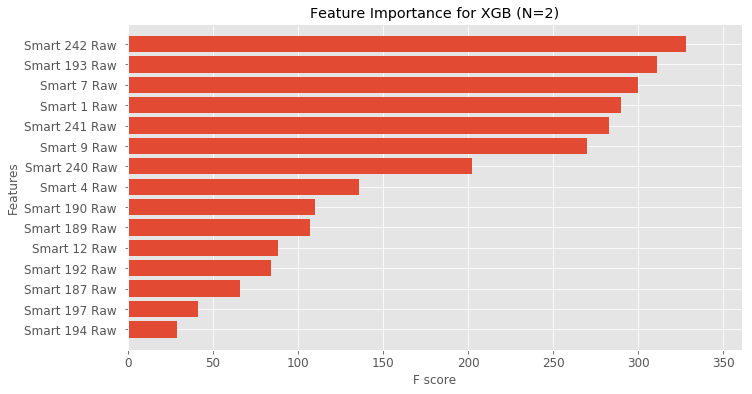

In [3]:
plot_importances('fail_today_or_tomorrow_xgb')

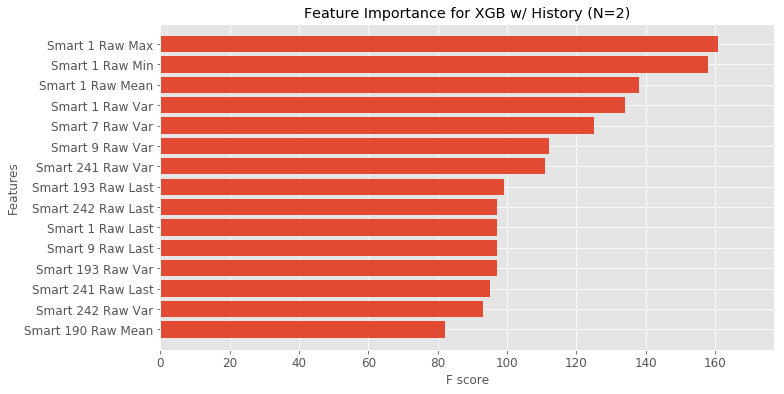

In [4]:
plot_importances('fail_today_or_tomorrow_xgb_history')

***NOTE:*** Rerun the above cell with the names of different models. 

### b) Shap

The above feature importances do not tell us anything about the diretionality with which each feature contributes to the prediction. However, this can be analysed through Shapley values. Shapley values are a concept borrowed from cooperative game theory. In essense, the shapley values correspond to the contribution of each feature (or "player") towards pushing the prediction (or "outcome") away from the expected value of the model.

Shapley values are problematic, as is the entire concept of trying to "explain" uninterpretable models. Given that interpretability is probably not a critical requirement for this use case, however, we can still use these tools as long as we take the results with a grain of salt. 

In [10]:
def get_test_data(test_location):
    """
    Function to get all test data 
    
    Parameters
    ----------
    test_location:
        Where test csv's are located
        
    Returns
    -------
    concatenated_df : DataFrame
        A dataframe containing all of the data from the csvs
    """
    # List the relevant files in the bucket
    files = glob.glob(os.path.join(test_location, '*.csv'))
    # Read the files, concatenate them, and sort by date
    # df_for_each_blob = (pd.read_csv(file) for file in files)
    concatenated_df = pd.concat(pd.read_csv(file) for file in files).sort_values('date')
    # Some drives failed between Jan 1st and Jan 10th, we remove them here
    # (This could also just have been done in BQ ahead of time)
    already_removed_drives = concatenated_df[(concatenated_df['failure'] == 1) 
                                             & (concatenated_df['date'] < '2019-01-10')]['serial_number'].values
    concatenated_df = concatenated_df[~concatenated_df['serial_number'].isin(already_removed_drives)]
    
    return concatenated_df

class PredictionExplainer():
    """
    Class to explain individual predictions of a machine learning model 
    by plotting shap values and displaying features used to make a decision
    """
    def __init__(self, test_data, model):
        self.test_data = test_data
        
        self.model_name = model
        loaded_model = get_model(self.model_name, MODEL_PATH)
        self.model = loaded_model
        
    def _define_window(self, serial_number, date):
        """
        Define a window of data according to the date for which we'd like to explain
        the prediction
        """
        dates = pd.date_range(end=date, periods=10)
        dates = [str(date).split(' ')[0] for date in dates]
        
        return self.test_data[(self.test_data['serial_number'] == serial_number) 
                              & (test_data['date'].isin(dates))]
        
    def _get_features(self, window):
        """
        Get features for a window of data
        """        
        feat_cols = [col for col in self.test_data.columns if 'raw' in col]
        if 'history' in self.model_name:
            aggs = ['last', np.mean, np.var, 'min', 'max']
        else:
            aggs = ['last']
        features = window.groupby('serial_number').agg(['last'])[feat_cols]
        
        return features
    
    def _get_important_features_as_frame(self, window, features, shap_values):
        """
        Get important features according to shap as a dataframe
        """
        idx = np.argsort(abs(shap_values[0]))[-10:]
        top_feats = features.columns[idx[::-1]]
        frame = features[top_feats]
        frame.columns = [('_').join(col) for col in top_feats]
        
        prediction = self.model.predict(features)
        frame['prediction'] = prediction
        frame['failure'] = window['failure'].iloc[-1]

        return frame
    
    def explain_prediction(self, serial_number, date, plot=True, display_frame=True):
        """
        Explain the prediction of an ML model for a particular
        serial number on a particular date
        
        Parameters
        ----------
        serial_number : str
            Name of the hard drive
            
        date : str
            Date of the prediction
            
        plot : bool
            Whether to display a shap summary plot
            
        display_frame : bool
            Whether to display important features as a data frame
            
        Returns
        -------
        """
        window = self._define_window(serial_number, date)
        features = self._get_features(window)
        
        # Random fix for binary issue with SHAP 3.5
        my_model = self.model.get_booster()
        model_bytearray = my_model.save_raw()[4:]
        my_model.save_raw = lambda: model_bytearray
#         def myfun(self=None):
#             return model_bytearray
#             my_model.save_raw = myfun
        
        explainer_shap = shap.TreeExplainer(my_model)
        shap_values = explainer_shap.shap_values(features)
        
        self.frame = self._get_important_features_as_frame(window, 
                                                      features, 
                                                      shap_values)
        
        if plot:
            shap.summary_plot(shap_values, features, max_display=10)
        if display_frame:
            display(self.frame)

In [11]:
test_data = get_test_data(HDD_PATH)

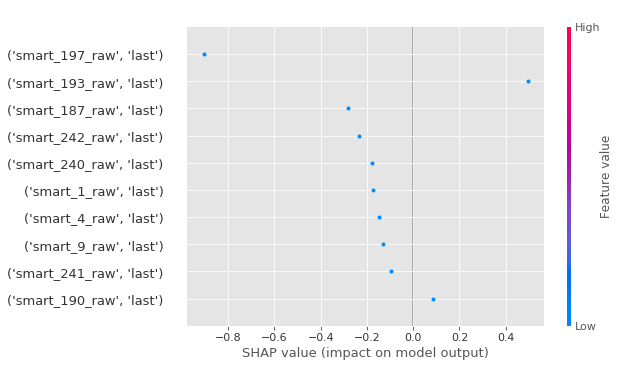

,smart_197_raw_last,smart_193_raw_last,smart_187_raw_last,smart_242_raw_last,smart_240_raw_last,smart_1_raw_last,smart_4_raw_last,smart_9_raw_last,smart_241_raw_last,smart_190_raw_last,prediction,failure
serial_number,,,,,,,,,,,,
S301K6TS,0.0,7474.0,0.0,1.109044e+11,28462.0,208398328.0,4.0,28562.0,4.851817e+10,25.0,0,0


In [17]:
# Explainer for the 50_50_fail_today model
xgb_N1_explainer = PredictionExplainer(test_data, 'fail_today_xgb')

# Explain individual predictions
xgb_N1_explainer.explain_prediction('S301K6TS', '2019-01-10')

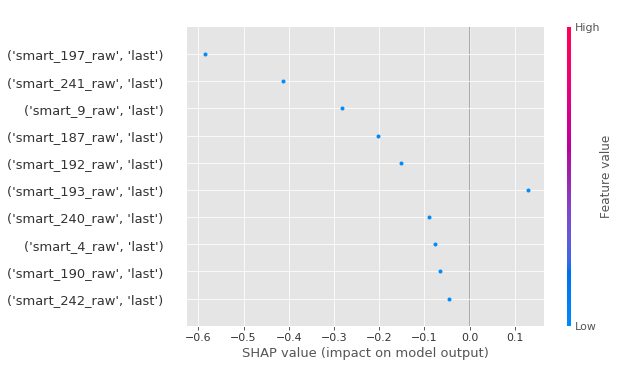

,smart_197_raw_last,smart_241_raw_last,smart_9_raw_last,smart_187_raw_last,smart_192_raw_last,smart_193_raw_last,smart_240_raw_last,smart_4_raw_last,smart_190_raw_last,smart_242_raw_last,prediction,failure
serial_number,,,,,,,,,,,,
S301K6TS,0.0,4.851817e+10,28562.0,0.0,0.0,7474.0,28462.0,4.0,25.0,1.109044e+11,0,0


In [18]:
xgb_N7_explainer = PredictionExplainer(test_data, 'fail_this_week_xgb')

xgb_N7_explainer.explain_prediction('S301K6TS', '2019-01-10')

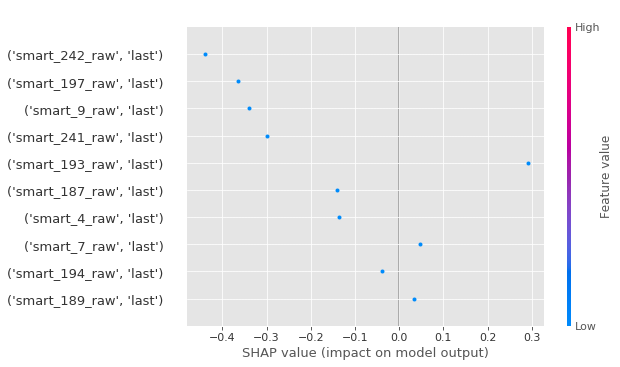

,smart_242_raw_last,smart_197_raw_last,smart_9_raw_last,smart_241_raw_last,smart_193_raw_last,smart_187_raw_last,smart_4_raw_last,smart_7_raw_last,smart_194_raw_last,smart_189_raw_last,prediction,failure
serial_number,,,,,,,,,,,,
S301K6TS,1.109044e+11,0.0,28562.0,4.851817e+10,7474.0,0.0,4.0,400838388.0,25.0,0.0,0,0


In [20]:
xgb_N30_explainer = PredictionExplainer(test_data, 'fail_this_month_xgb')

xgb_N30_explainer.explain_prediction('S301K6TS', '2019-01-10')

In [22]:
# For some reason the above works, but this doesn't
# Future updates to shap should fix this issue
# NOTE unofficial shap 0.36 does have a fix set, but another error is preventing it's use

# xgb_N1_explainer.explain_prediction('S300Z8P7', '2019-04-24')